In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nlp_project.notebook_utils import compact_split, evaluate
import evaluate as ev

In [18]:
# Various functions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def report(trainer, test_set, labels, model_name=None):
    preds = trainer.predict(test_set)
    y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
    
    if model_name is not None:
        print(model_name)
    
    evaluate(test_set['label'], y_pred, labels)
    

def import_model(model_name, labels, device):
    transformer = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(labels)
    )
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    transformer = transformer.to(device)
    
    return transformer, tokenizer

    
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding='max_length', 
                     truncation=True, 
                     max_length=max_length)
    

def clean_gpu_memory(transformer, tokenizer):
    del transformer
    del tokenizer
    torch.cuda.empty_cache()

@torch.no_grad()
def predict(transformer, text, labels):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = transformer(**input_encodings)
    
    lbl = labels[torch.argmax(outputs.logits).item()]

    return lbl

In [3]:
# Seed for reproducibility
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)
df['label'] = df['label'].replace({'human':0, 'generated':1})

labels = ['human', 'generated']
max_length = 135

df

,text,label
0,you need to stop the engine and wait until it ...,1
1,The Commission shall publish the report; an in...,1
2,"I have not been tweeting a lot lately, but I d...",1
3,I pass my exam and really thankgod for that bu...,0
4,The template will have 3 parts: a mustache sha...,0
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",0
33841,10. Article 13 of Council Directive 80/777/EEC...,0
33842,"Crying because I have to cry for you?. No. No,...",1
33843,"However, it will continue to offer customers a...",1


In [5]:
train, val, test = compact_split(df, test_size=0.1, val_size=0.1, seed=seed)

data = DatasetDict()
data['train'] = Dataset.from_pandas(train)
data['validation'] = Dataset.from_pandas(val)
data['test'] = Dataset.from_pandas(test)

metric = ev.load("accuracy")

In [6]:
model_name = 'bert-base-multilingual-uncased'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0,
    num_train_epochs=2,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Map:   0%|          | 0/27076 [00:00<?, ? examples/s]

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/3385 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.472100,0.371124,0.838948
200,0.377400,0.349224,0.864657
300,0.357100,0.312287,0.871454
400,0.291500,0.276816,0.882979
500,0.291700,0.304933,0.878546
600,0.265000,0.281335,0.887116
700,0.267900,0.285954,0.884161
800,0.248400,0.462273,0.821217
900,0.190100,0.316253,0.891844
1000,0.125800,0.305912,0.894504


bert-base-multilingual-uncased
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1749
           1       0.90      0.87      0.89      1636

    accuracy                           0.89      3385
   macro avg       0.89      0.89      0.89      3385
weighted avg       0.89      0.89      0.89      3385



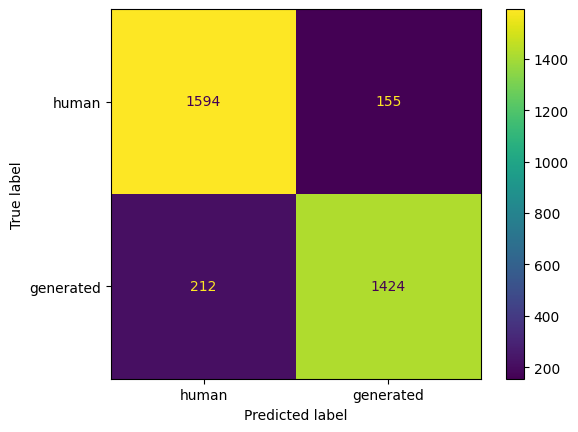

In [7]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [8]:
clean_gpu_memory(transformer, tokenizer)

In [9]:
model_name = 'bert-base-multilingual-cased'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.3,
    num_train_epochs=2,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Map:   0%|          | 0/27076 [00:00<?, ? examples/s]

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/3385 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.505500,0.358429,0.846927
200,0.364800,0.428794,0.818853
300,0.351500,0.319890,0.858156
400,0.289000,0.315750,0.864362
500,0.293400,0.248889,0.896277
600,0.267900,0.275989,0.884161
700,0.264300,0.292810,0.883274
800,0.237900,0.439222,0.825650
900,0.202200,0.264716,0.901300
1000,0.134200,0.398508,0.882683


bert-base-multilingual-cased
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1749
           1       0.89      0.96      0.92      1636

    accuracy                           0.92      3385
   macro avg       0.93      0.92      0.92      3385
weighted avg       0.93      0.92      0.92      3385



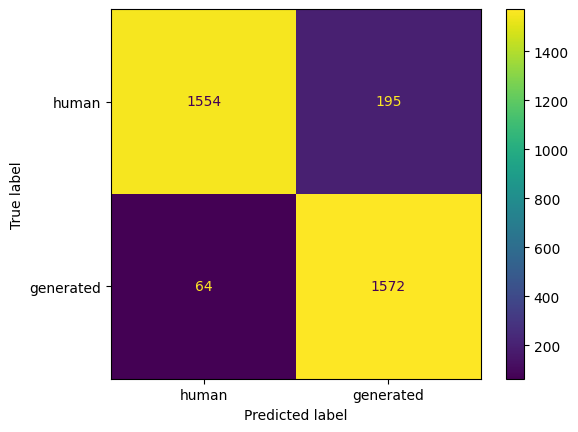

In [10]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [11]:
model_name = 'distilbert-base-multilingual-cased'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.2,
    num_train_epochs=3,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classif

Map:   0%|          | 0/27076 [00:00<?, ? examples/s]

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/3385 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.486400,0.378160,0.824468
200,0.382000,0.404014,0.818262
300,0.341800,0.303985,0.864657
400,0.285500,0.268283,0.882979
500,0.300200,0.289271,0.877364
600,0.268700,0.266364,0.888889
700,0.261700,0.322295,0.867021
800,0.241400,0.376510,0.837470
900,0.189700,0.396603,0.855201
1000,0.128200,0.329825,0.899823


distilbert-base-multilingual-cased
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1749
           1       0.93      0.92      0.92      1636

    accuracy                           0.93      3385
   macro avg       0.93      0.93      0.93      3385
weighted avg       0.93      0.93      0.93      3385



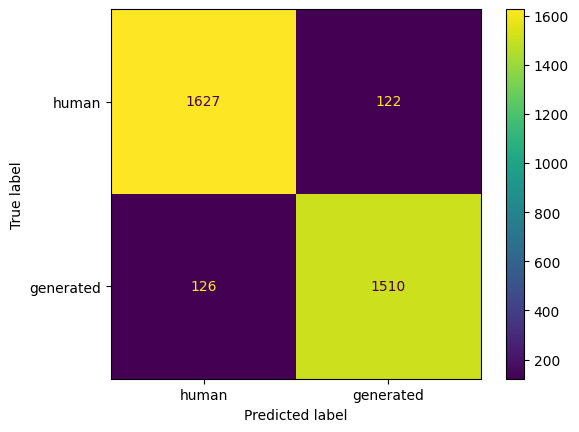

In [12]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [13]:
clean_gpu_memory(transformer, tokenizer)

In [14]:
model_name = 'xlm-roberta-base'

transformer, tokenizer = import_model(model_name, labels, device)
tokenized_data = data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir=f'models/{model_name}',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.2,
    num_train_epochs=3,
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=transformer, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Map:   0%|          | 0/27076 [00:00<?, ? examples/s]

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/3385 [00:00<?, ? examples/s]

/home/crimsowl/.cache/pypoetry/virtualenvs/nlp-project-7TuoKFiO-py3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.577800,0.503036,0.807624
200,0.419900,0.408273,0.833333
300,0.356000,0.518808,0.806442
400,0.287700,0.382262,0.834220
500,0.264000,0.294953,0.876773
600,0.256000,0.312359,0.872340
700,0.268600,0.423798,0.830674
800,0.226000,0.520898,0.818853
900,0.199100,0.479740,0.858452
1000,0.160100,0.323108,0.904255


xlm-roberta-base
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1749
           1       0.83      0.96      0.89      1636

    accuracy                           0.89      3385
   macro avg       0.89      0.89      0.89      3385
weighted avg       0.89      0.89      0.89      3385



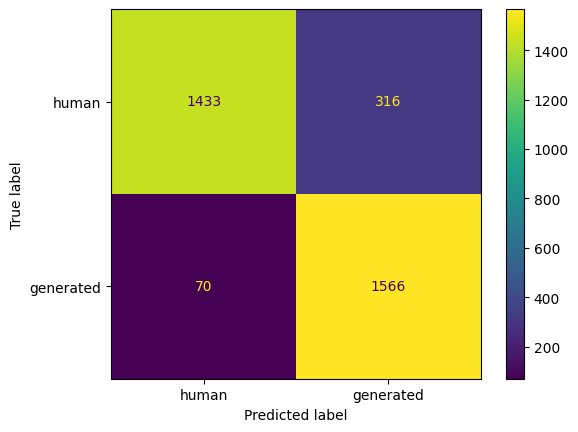

In [15]:
trainer.train()
report(trainer, tokenized_data['test'], labels, model_name)

In [19]:
# This is text generated by ChatGPT when prompted:
# "Explain in a short sentence why the natural language processing field is cool"
sample_text = 'The natural language processing field is cool because it enables machines to understand, interpret, and generate human language, which has numerous real-world applications.' 
predict(transformer, sample_text, labels)

'generated'